Importing libraries

In [1]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import Tfidf_patentsVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import ward, dendrogram
from sklearn import decomposition

import numpy as np
import pandas as pd

import spacy
import re


from spacy.lang.en.stop_words import STOP_WORDS
stopword_list = list(STOP_WORDS)
nlp_en = spacy.load('en_core_web_sm')

In [3]:
df_patents = pd.read_csv("patents_30.csv") #loading dataframe
df_patents   

,AE,TI,AB,Year,CP,AE_ABBREV
0,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for handshaking terminal in radio commu...,NOVELTY - The method involves noticing firs...,2018,WO2018084624-A1 -- WO2010082775-A2 LG ELECTR...,(SMSU-C)
1,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for handling control data by mobility m...,NOVELTY - The method involves receiving a n...,2018,WO2018008977-A1 -- KR2013103428-A SAMSUNG EL...,(SMSU-C)
2,HUAWEI TECHNOLOGIES CO LTD (HUAW-C),Method for receiving channel state information...,NOVELTY - The method involves receiving a n...,2017,WO2017114474-A1 -- CN101394378-A INNOFIDEI T...,(HUAW-C)
3,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for receiving signal in receiving appar...,NOVELTY - The method involves decoding a co...,2017,US2017187491-A1 -- US20050216821-A1 ; US788...,(SMSU-C)
4,QUALCOMM INC (QCOM-C),Wireless communication method for over-the-air...,NOVELTY - The method involves receiving (50...,2018,; WO2018236480-A1 -- EP2154802-A1 MITSUBISH...,(QCOM-C)
...,...,...,...,...,...,...
7622,QUALCOMM INC (QCOM-C),Feedback method for use in wireless communicat...,NOVELTY - The method involves identifying a...,2020,US2020259532-A1 -- US20100034303-A1 ; US201...,(QCOM-C)
7623,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Idle mode measurement method for supporting ca...,NOVELTY - The idle mode measurement method ...,2020,; WO2020166895-A1 -- KR1616253-B1 LG ELECTR...,(SMSU-C)
7624,VIVO MOBILE COMMUNICATION CO LTD (BBKO-C),Signal processing circuit for use in a mobile ...,NOVELTY - The signal processing circuit com...,2020,CN111525941-A -- CN101835250-A HUAWEI DEVICE...,(BBKO-C)
7625,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Transmission method using electronic device in...,NOVELTY - The method (300) involves obtaini...,2020,WO2020159303-A1 -- US20160135239-A1,(SMSU-C)


In [4]:
!pip install nlp
!pip install spacy
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 6.5 MB/s 
     |████████████████████████████████| 212 kB 16.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-08-09 04:36:55.415271: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 14.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
# concatenating for forming the text column

In [6]:
df_patents['text'] = df_patents['TI'] + ". " + df_patents['AB'] #title followed by a period and then the abstractdf_patents
df_patents.head()

,AE,TI,AB,Year,CP,AE_ABBREV,text
0,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for handshaking terminal in radio commu...,NOVELTY - The method involves noticing firs...,2018,WO2018084624-A1 -- WO2010082775-A2 LG ELECTR...,(SMSU-C),Method for handshaking terminal in radio commu...
1,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for handling control data by mobility m...,NOVELTY - The method involves receiving a n...,2018,WO2018008977-A1 -- KR2013103428-A SAMSUNG EL...,(SMSU-C),Method for handling control data by mobility m...
2,HUAWEI TECHNOLOGIES CO LTD (HUAW-C),Method for receiving channel state information...,NOVELTY - The method involves receiving a n...,2017,WO2017114474-A1 -- CN101394378-A INNOFIDEI T...,(HUAW-C),Method for receiving channel state information...
3,SAMSUNG ELECTRONICS CO LTD (SMSU-C),Method for receiving signal in receiving appar...,NOVELTY - The method involves decoding a co...,2017,US2017187491-A1 -- US20050216821-A1 ; US788...,(SMSU-C),Method for receiving signal in receiving appar...
4,QUALCOMM INC (QCOM-C),Wireless communication method for over-the-air...,NOVELTY - The method involves receiving (50...,2018,; WO2018236480-A1 -- EP2154802-A1 MITSUBISH...,(QCOM-C),Wireless communication method for over-the-air...


# cleaning the corpus for preprocessing

In [ ]:
def preprocess(txt):
    txt = txt.lower() 
    
    #normalize text

    txt = re.sub(r'[^a-zA-Z]', ' ', txt)

    docs = nlp_en(txt)

    #lemmatize 
    # remove stopwords
    word_list = [doc.lemma_ for doc in docs if doc.text 
                            not in stopword_list ]
    txt = " ".join(word_list)

    txt = txt.replace("-PRON-","")

    txt = txt.replace("PRON","")
    return txt

# 40 topics NMF using Tfidf_patents vectorizer

In [ ]:
corpus = list(df_patents['text'])

In [ ]:
cleaned_corpus = [preprocess(txt) for txt in corpus]
vectorizer_nmf = Tfidf_patentsVectorizer(stop_words = 'english', min_df_patents = 2)
dtm_nmf = vectorizer_nmf.fit_transform(cleaned_corpus)

In [ ]:
vocab = vectorizer_nmf.get_feature_names_out()
num_topics = 40
num_top_words = 20
clf = decomposition.NMF(n_components = num_topics, random_state=40)
doctopic = clf.fit_transform(dtm_nmf)
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: control downlink dci pdcch search space physical monitor pdsch set candidate receive monitoring tci format
Topic 1: network core access element equipment connection user radio method generation area traffic second facilitate public
Topic 2: device send mobile phone computer electronic second network indication facilitate telephone personal instruction step cellular
Topic 3: ue equipment user mode location capability nr rat processor radio bs connection method associate procedure
Topic 4: unit control mobile radio user communication lte ieee access reception future advanced generation new ultra
Topic 5: antenna module electronic circuit second array element connect surface radiator conductive structure switch form substrate
Topic 6: beam failure recovery quality candidate pair select set receive form reception determine direction bfr procedure
Topic 7: station base transmit receive radio rrc interference connection fourth generation second smart secondary method claim
Topic 8: 

C:\Users\nasre\AppData\Roaming\Python\Python38\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
from gensim.corpora import Dictionary
n=40
cleaned_corpus = [txt.split() for txt in cleaned_corpus]
dictionary = Dictionary(cleaned_corpus)
dictionary.filter_extremes(no_below=10, no_above=0.8)

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in cleaned_corpus] # Bag-of-words

In [ ]:
# Doing LDA 
from gensim.models import LdaModel
num_topics = 40 #params
chunksize = 3000
passes = 40
iterations = 1000
eval_every = None 

# index to word dict
temp = dictionary[0]  
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
top_topics = model.top_topics(corpus) 
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -2.1931.
[([(0.10339611, 'unit'),
   (0.078223355, 'terminal'),
   (0.07483387, 'control'),
   (0.055091236, 'system'),
   (0.04337746, 'user'),
   (0.037486933, 'mobile'),
   (0.03622707, 'transmission'),
   (0.030601671, 'information'),
   (0.02934308, 'wireless'),
   (0.026183823, 'base'),
   (0.026023941, 'apparatus'),
   (0.018417936, 'station'),
   (0.01726244, 'reception'),
   (0.0154390745, 'radio'),
   (0.01482697, 'text'),
   (0.014783277, 'language'),
   (0.014766645, 'english'),
   (0.012872245, 'non'),
   (0.012475935, 'receive'),
   (0.010870639, 'lte')],
  -0.6998266516532594),
 ([(0.19582018, 'information'),
   (0.07091244, 'terminal'),
   (0.038750987, 'send'),
   (0.03484177, 'device'),
   (0.034432147, 'system'),
   (0.030180426, 'involve'),
   (0.029411845, 'accord'),
   (0.024220537, 'receive'),
   (0.023300584, 'step'),
   (0.022873431, 'determine'),
   (0.022623125, 'indication'),
   (0.020727994, 'non'),
   (0.020598272, 'text'),
   (0.0

In [ ]:
for i in range(40):  #printing the 40 topics and the words in them
    print("Topic: " + str(i + 1) + ":")
    a, b = zip(*top_topics[i][0])
    for w in b:
        print(w, end=', ')
    print("\n")    

Topic: 1:
unit, terminal, control, system, user, mobile, transmission, information, wireless, base, apparatus, station, reception, radio, text, language, english, non, receive, lte, 

Topic: 2:
information, terminal, send, device, system, involve, accord, receive, step, determine, indication, non, text, english, language, computer, obtain, storage, instruction, medium, 

Topic: 3:
terminal, device, system, mobile, send, network, step, access, division, lte, target, determine, set, aa, evolution, information, involve, term, long, comprise, 

Topic: 4:
network, device, wireless, access, second, core, cellular, radio, computer, program, provide, establish, comprise, medium, follow, involve, instruction, receive, allow, control, 

Topic: 5:
system, lte, radio, access, mobile, evolution, term, long, new, advanced, nr, technology, ieee, telecommunication, e, ultra, gsm, global, limit, code, 

Topic: 6:
carrier, system, multiple, wireless, division, symbol, frequency, access, sub, base, ortho

# Hierarchical cluster, MDS Map 

In [ ]:
df_patents['Lemmatized'] = [preprocess(txt) for txt in df_patents['text'].tolist()]

In [ ]:
comp = list(set(df_patents['AE_ABBREV'].tolist()))
corpus1 = []
for company in comp:
    alist = ' '.join(df_patents[df_patents['AE_ABBREV'] == company]['Lemmatized'].tolist())
    corpus1.append(alist)

In [ ]:
print(comp)

['(CHGY-C)', '(BBKO-C)', '(OYNO-C)', '(FUIT-C)', '(AMTT-C)', '(KTKT-C)', '(SONY-C)', '(XIAO-C)', '(ZTEC-C)', '(GDOP-C)', '(MTEK-C)', '(QCOM-C)', '(GLDS-C)', '(NIDE-C)', '(TELF-C)', '(SHAF-C)', '(VEZN-C)', '(ITLC-C)', '(TMOB-C)', '(SMSU-C)', '(CNMO-C)', '(NITE-C)', '(APPY-C)', '(HUAW-C)', '(CUNC-C)', '(FGIN-C)', '(DTCO-C)']


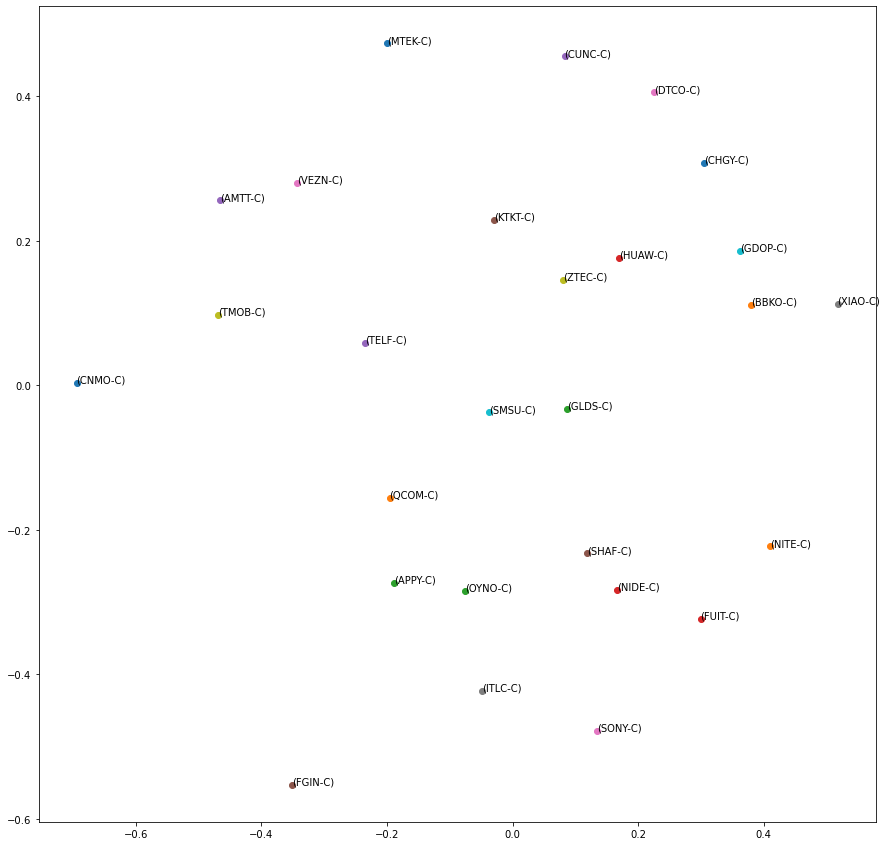

In [ ]:
ctorize_x = CountVectorizer(stop_words = 'english', min_df_patents = 2, max_df_patents = 0.95, max_features=10000)
dtm = vectorize_x.fit_transform(corpus1)
similarity = cosine_similarity(dtm)  
cos_distance = 1 - similarity

mds = MDS(n_components = 2, dissimilarity='precomputed', random_state=48)
pos = mds.fit_transform(cos_distance)
xs, ys = pos[:,0], pos[:,1]
plt.figure(figsize=(15, 15))
for x, y, name in zip(xs, ys, comp):
    plt.scatter(x, y)
    plt.text(x, y, name)
plt.show()

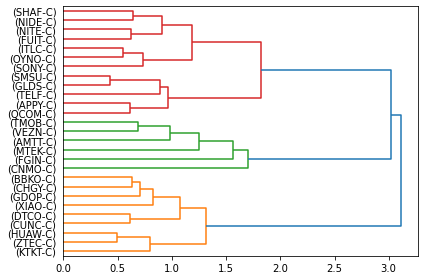

In [ ]:
linkage_matrix = ward(cos_distance)
dendrogram(linkage_matrix, orientation='right',labels=comp)
plt.tight_layout()
plt.show()